# 0.0 Imports

In [112]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import datetime
import matplotlib.gridspec as gridspec
from tabulate import tabulate
from scipy import stats as ss

In [81]:
# redefine tamanho das tabelas
plt.rcParams['figure.figsize']=(15,15)

## 0.1 Helper Functions

## 0.2 Loading data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [3]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
506867,328,4,2014-04-03,5290,596,1,1,0,0,a,a,3130.0,7.0,2002.0,0,NaN,NaN,NaN


# 1.0 Descrição dos dados

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

#renomear
df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
#verifica o número de linhas e colunas

print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [9]:
## Verifica se os dados estão no tipo correto
df1['date'] = pd.to_datetime(df1['date'])

In [10]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
#competition_distance
#substitui os NA e matém os valores existentes nas demais 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                      
#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [14]:
df1.sample(5).T

,547617,775810,277010,880396,928292
store,938,556,507,332,283
day_of_week,3,1,2,5,4
date,2014-02-26 00:00:00,2013-08-05 00:00:00,2014-11-18 00:00:00,2013-05-03 00:00:00,2013-03-21 00:00:00
sales,7021,6955,5298,4064,6622
customers,796,870,470,546,685
open,1,1,1,1,1
promo,0,0,0,1,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,d,a,a,a


## 1.6 Change Types

In [15]:
#Após fazer transformações em colunas é bom chegar para ver se o seu tipo não foi mudado 
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical 

In [18]:
num_attributes = df1.select_dtypes(include =['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'int32', 'datetime64[ns]'])

In [19]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
414154,160,3,4171,459,1,0,0,17110.0,11,2005,0,26,2014,0
759926,282,1,3821,636,1,0,0,1220.0,12,2010,0,34,2013,0


## 1.7.1 Numerical Attributes

In [20]:
# Tendencia Central - Média e Mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T

# Dispersão - Desvio padrão, min, max, range (valor entre o min e o max), skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std) ).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#Concatenar essas métricas
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attributes','min','max','range','mean','median','std','skew','kurtosis'])
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2 Categorical Attributes

In [21]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

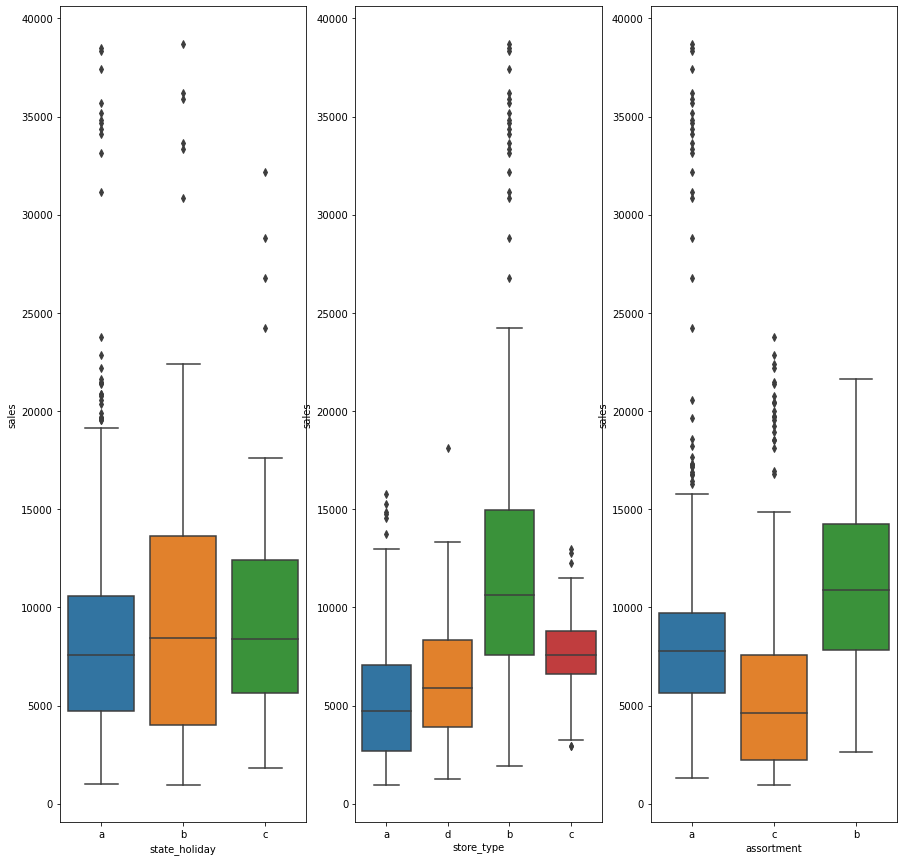

In [82]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature Engennering

## 2.0.1 Mapa mental de hipóteses

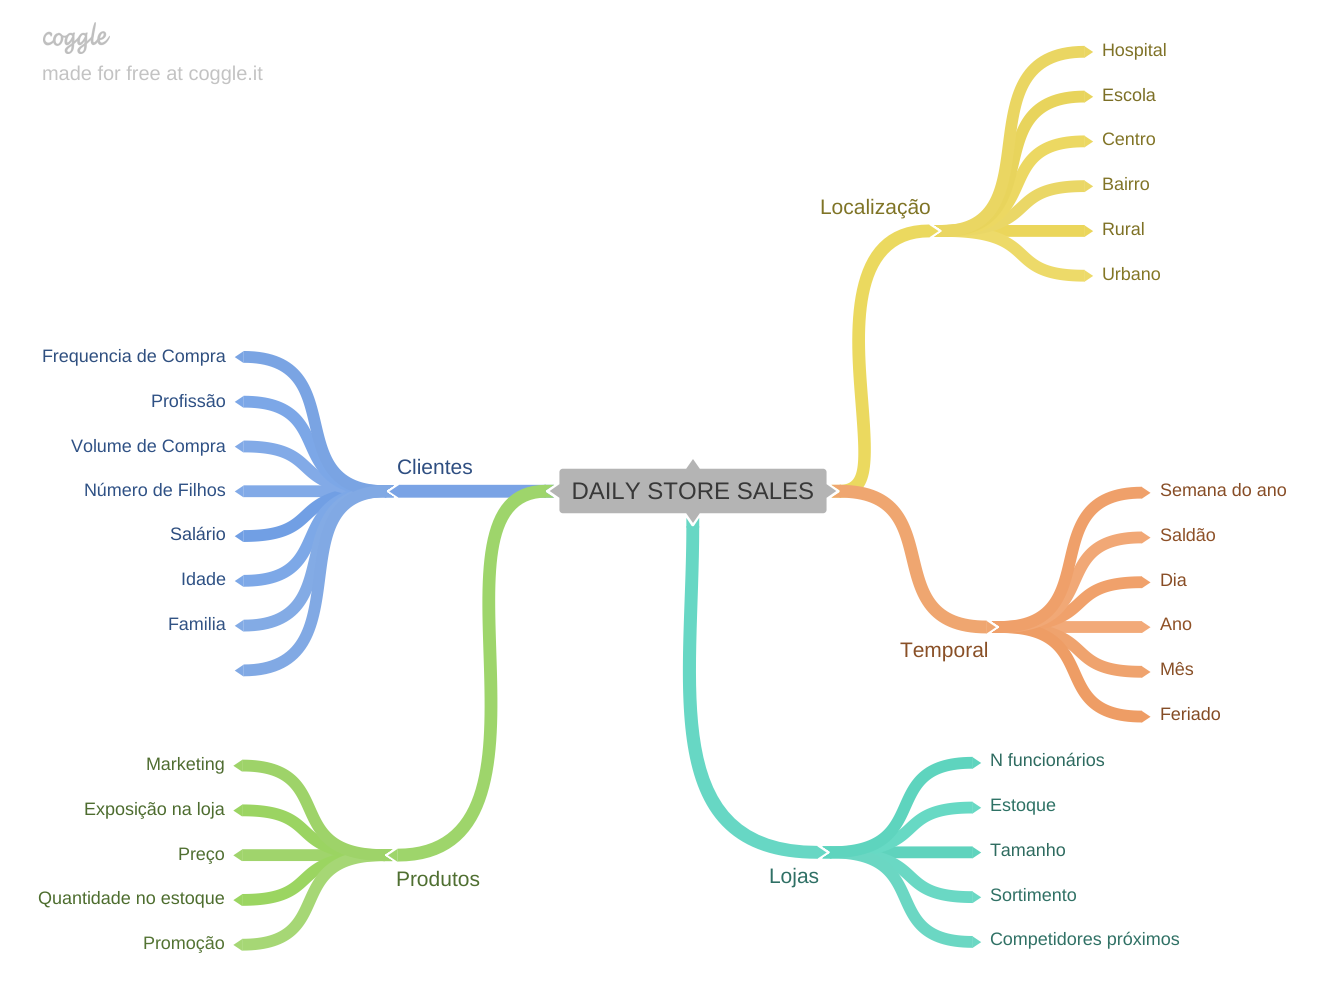

In [23]:
Image('img/mind_map.png')

## 2.1 Crição de Hipóteses

### 2.1.1 Hipótese de Loja

In [24]:
# 1 Lojas com maior quadro de funcionário deveriam vender mais.

# 2 Lojas com maior capacidade de estoque deveriam vender mais.

# 3 Lojas com maior porte deveriam vender mais.

# 4 Lojas com maior sortimentos deveriam vender mais.

# 5 Lojas com competidores mais próximos deveriam vender menos.

# 6 Lojas com competidores à mais tempo deveriam vender mais.


### 2.1.2 Hipótese de Produto

In [25]:
# 1 Lojas que investem mais em marketing deveriam vender mais.

# 2 Lojas que expõe mais o produto nas vitrines deveriam vender mais.

# 3 Lojas que tem preços menores nos produtos deveriam vender mais.

# 5 Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

# 6 Lojas com promoções ativas por mais tempo deveriam vender mais.

# 7 Lojas com mais divas de promoção deveriam vender mais.

# 8 Lojas com mais promoções consecutivas deveriam vender mais.


### 2.1.3 Hipótese Temporal

In [26]:
# 1 Lojas abertas durante o feriado de natal deveriam vender mais.

# 2 Lojas deveriam vender mais ao longo dos anos.

# 3 Lojas deveriam vender mais no segundo semestre do ano.

# 4 Lojas deveriam vender mais depois do dia 10 de cada mês.

# 5 Lojas deveriam vender menos aos finais de semana.

# 6 Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista final de hipóteses

In [27]:
# 1 Lojas com maior sortimentos deveriam vender mais.


# 2 Lojas com competidores mais próximos deveriam vender menos.


# 3 Lojas com competidores à mais tempo deveriam vender mais.


###################################################################
# 4 Lojas com promoções ativas por mais tempo deveriam vender mais.


# 5 Lojas com mais divas de promoção deveriam vender mais.


# 6 Lojas com mais promoções consecutivas deveriam vender mais.


##################################################################
# 7 Lojas abertas durante o feriado de natal deveriam vender mais.


# 8 Lojas deveriam vender mais ao longo dos anos.


# 9 Lojas deveriam vender mais no segundo semestre do ano.


# 10 Lojas deveriam vender mais depois do dia 10 de cada mês.


# 11 Lojas deveriam vender menos aos finais de semana.


# 12 Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [28]:
df2 = df1.copy()

In [29]:
# variáveis que vão ser derivadas da origintal
# ano
df2['year'] = df2['date'].dt.year

# mês
df2['month'] = df2['date'].dt.month

# dia
df2['day'] = df2['date'].dt.day

# semana do ano
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# semana do ano
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# ano competidor desde
df2['competition_since'] = df2.apply( lambda x: datetime.datetime (year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis =1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /30).apply(lambda x: x.days).astype(int)


# ano promoção desde
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta (days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days).astype(int)

# sortimento
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b'else 'extended')

# feriado estadual
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b'else 'christmas' if x == 'c'else 'regular_day')

In [30]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variáveis

In [31]:
df3 = df2.copy()

In [32]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [33]:
df3 = df3[(df3['open'] != 0) &  (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [34]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [35]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise exploratória de dados

In [36]:
# Os 3 objetivos da análise exploratória de dados
# Ganhar experiência de negócio
# Validar hipóteses de negócio (insights)
# Perceber variáveis que são importantes para o modelo

In [37]:
df4 = df3.copy()

## 4.1 Análise univariada

### 4.1.1 Response variable

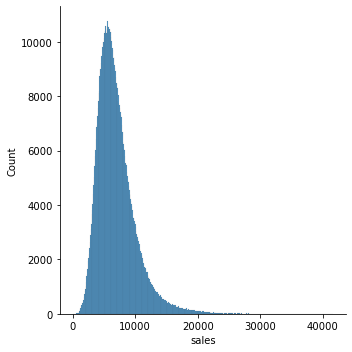

In [83]:
sns.displot(df4['sales'])

### 4.1.2 Numerical variable

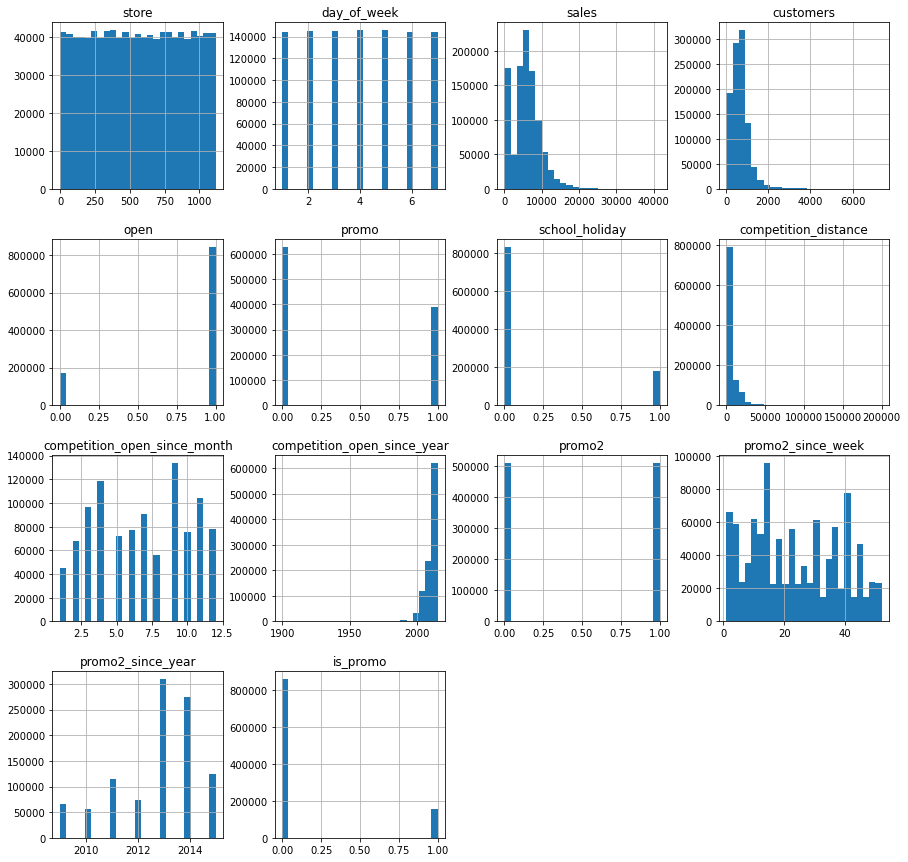

In [85]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical variable

In [40]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [41]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [42]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\Rodrigo\anaconda3\envs\rossmann-project\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\rossmann-project\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\rossmann-project\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

<AxesSubplot:xlabel='sales', ylabel='Density'>

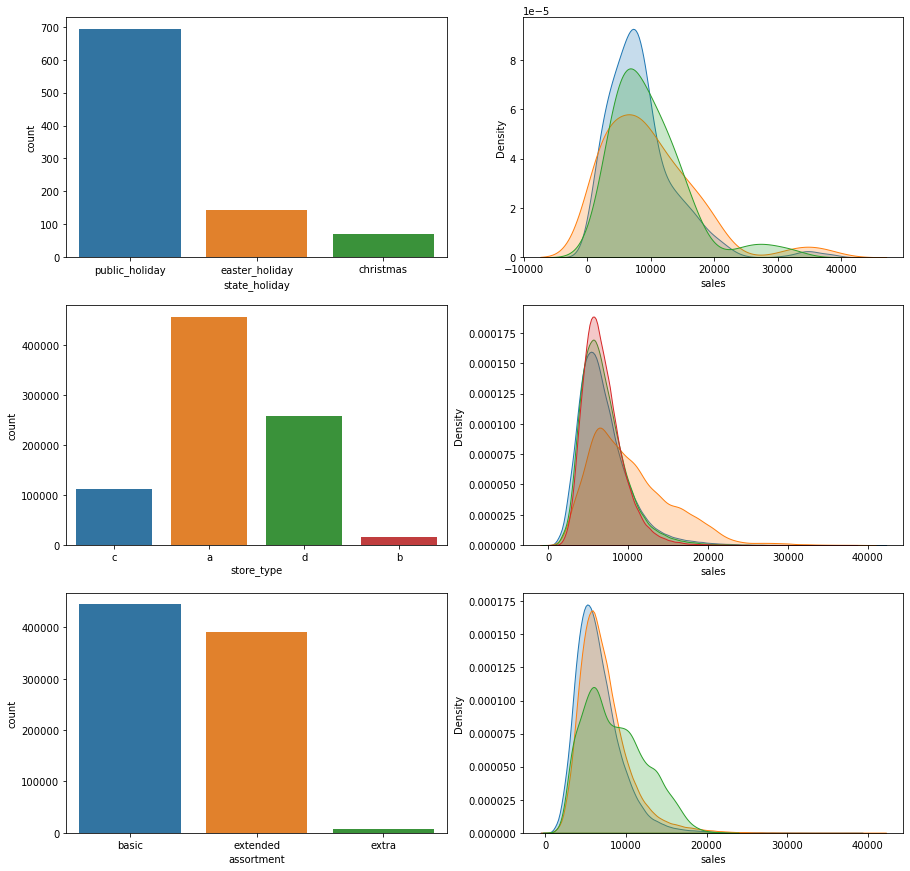

In [86]:
#state holiday
plt.subplot(3,2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot(3,2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3,2, 3)
sns.countplot( df4['store_type'] )

plt.subplot(3,2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3,2, 5)
sns.countplot( df4['assortment'] )

plt.subplot(3,2, 6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2 Análise bivariada

<AxesSubplot:xlabel='year_week'>

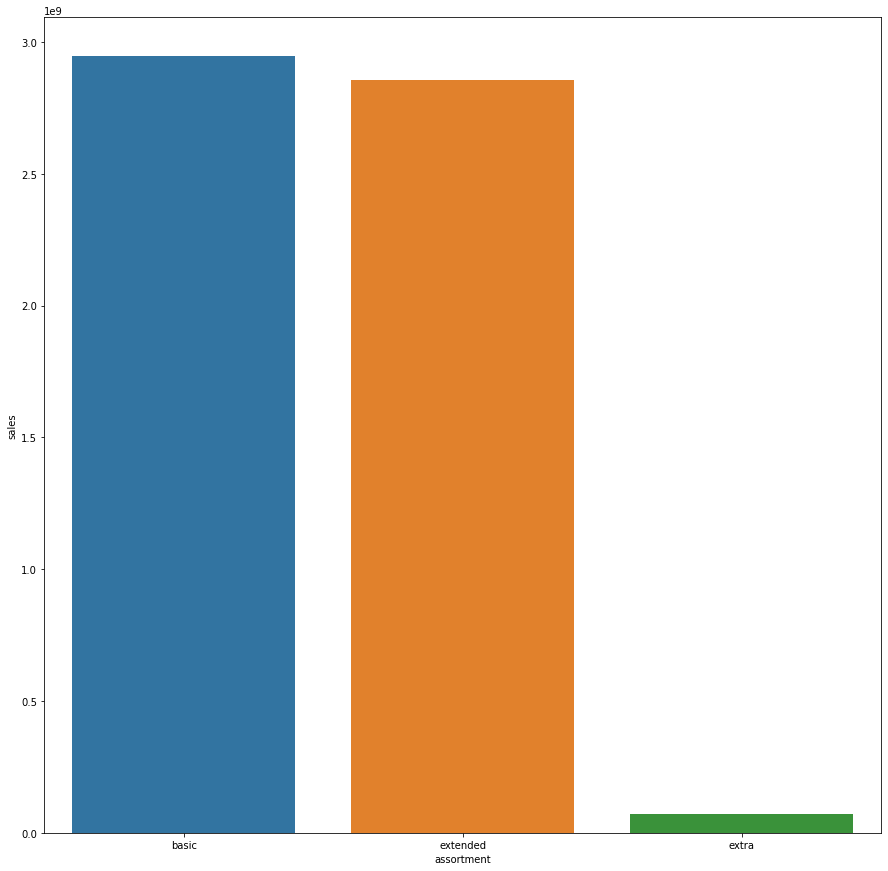

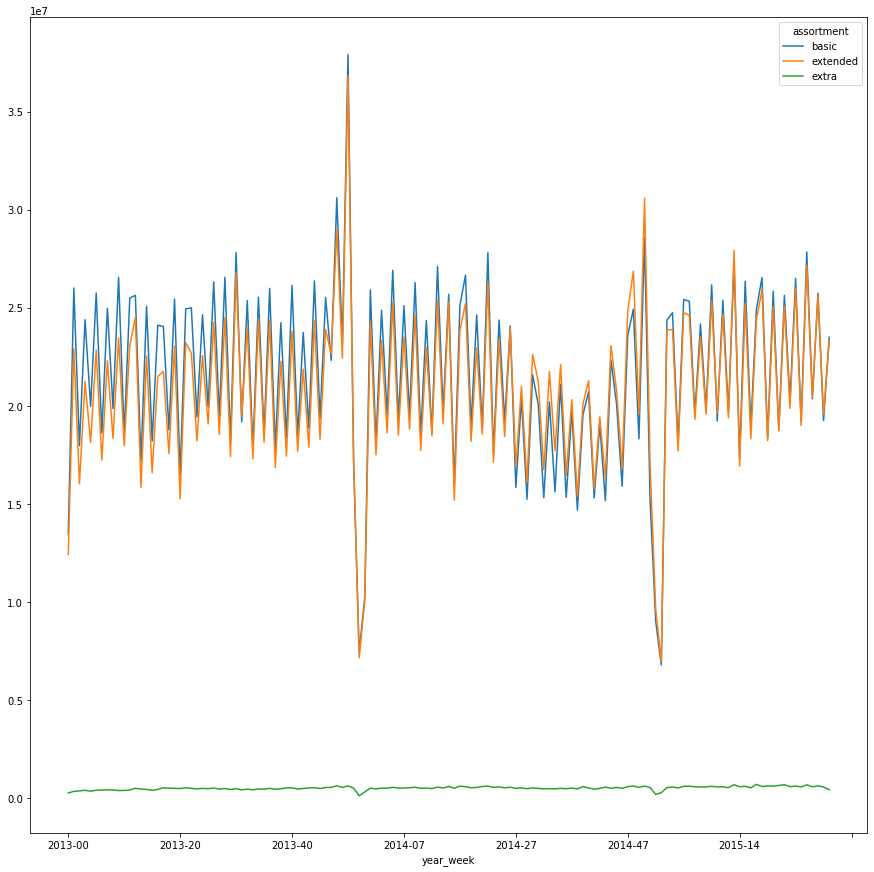

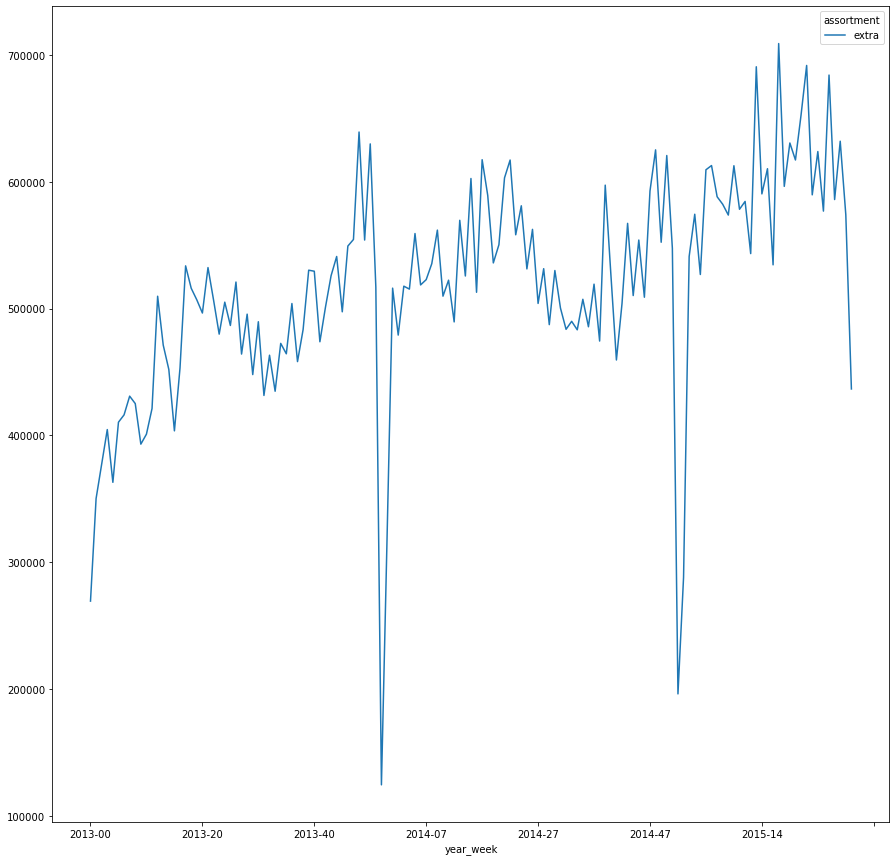

In [87]:
# 1 Lojas com maior sortimentos deveriam vender mais.
# Falso; lojas com maior sortimento (extra) vendem menos.

aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1);


aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()


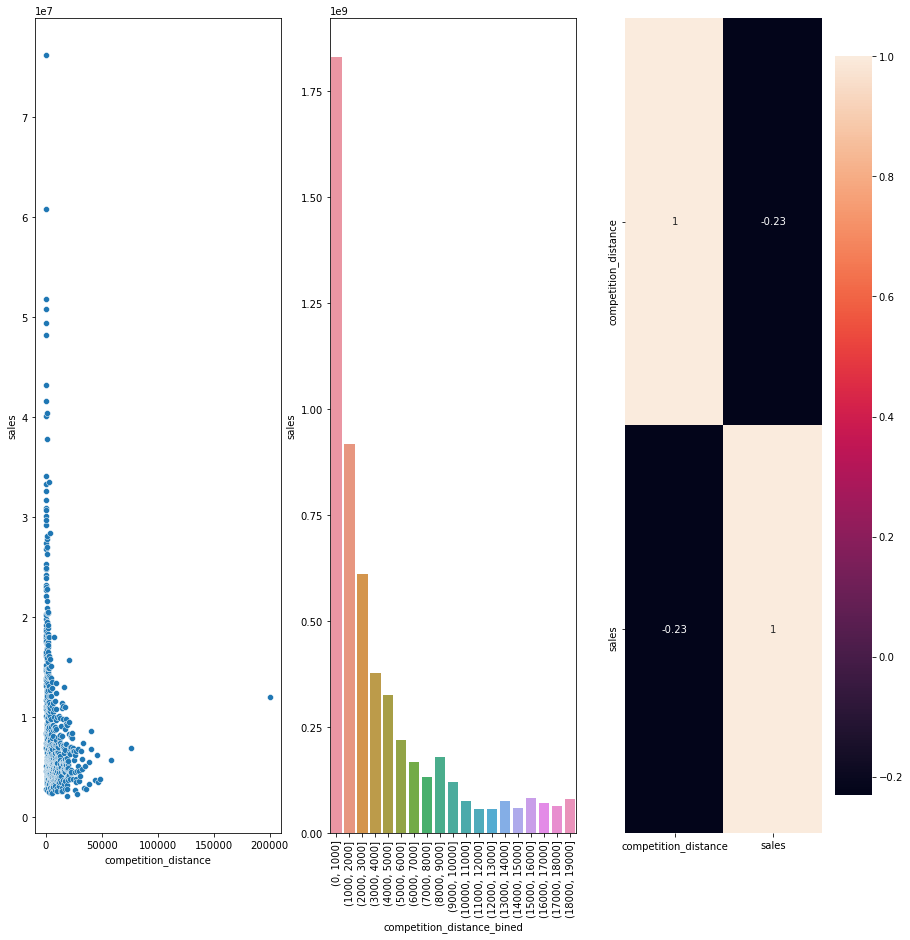

In [88]:
# 2 Lojas com competidores mais próximos deveriam vender menos.
# Falso; Na realidade lojas com competidores mais próximos, vendem mais e não menos.

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.scatterplot (x ='competition_distance', y='sales', data=aux1);

plt.subplot (1, 3, 2)
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_bined'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_bined', 'sales']].groupby('competition_distance_bined').sum().reset_index()
sns.barplot(x='competition_distance_bined', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr( method='pearson'), annot=True );



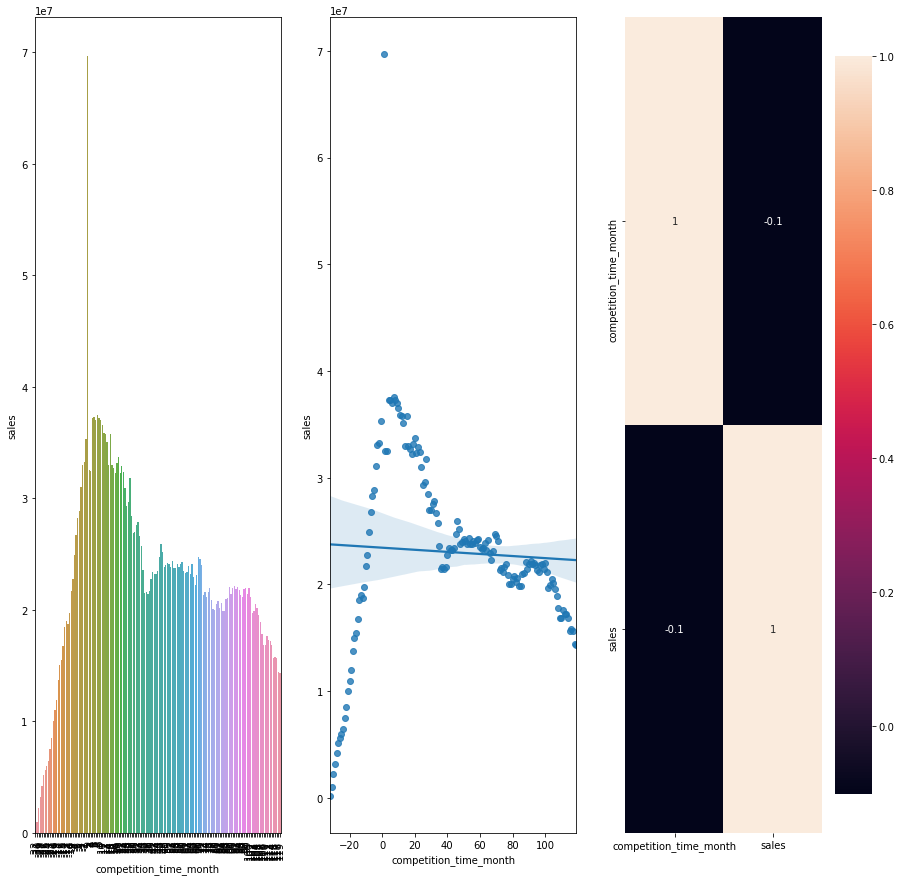

In [89]:
# 3 Lojas com competidores à mais tempo deveriam vender mais.
# Falso, lojas com competidores a mais tempo vendem menos;

plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks( rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);


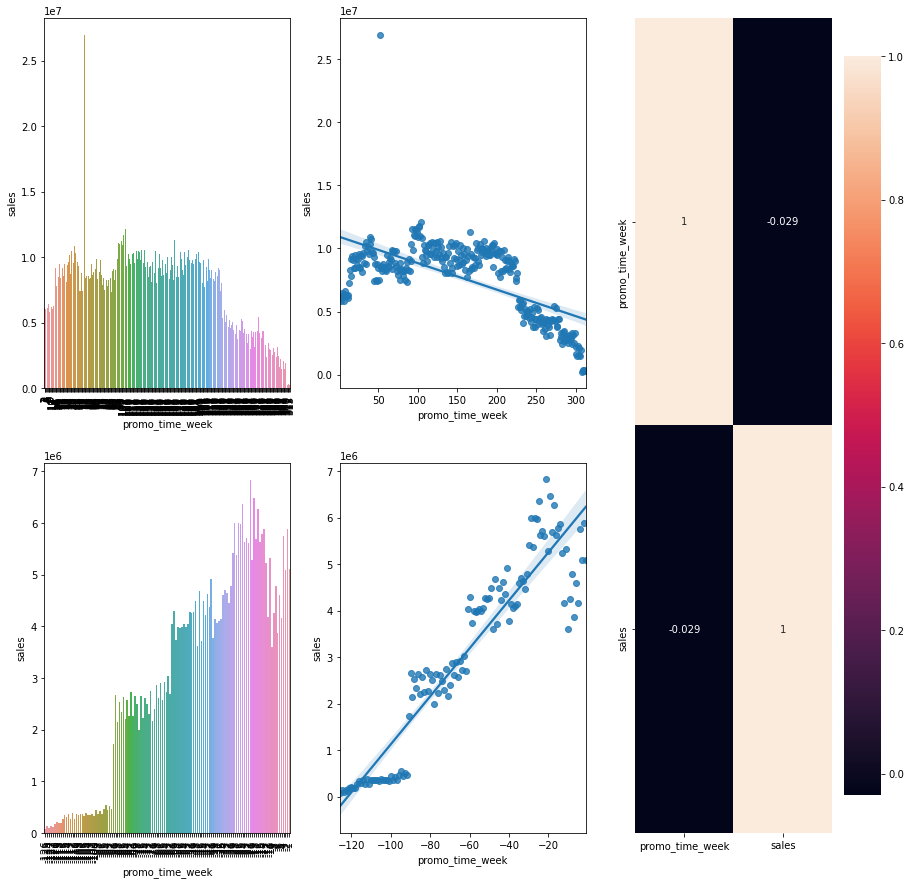

In [90]:
# 4 Lojas com promoções ativas por mais tempo deveriam vender mais.
# Falso, promoções ativas por mais tempo vendem regularmente durante um periodo e depois vai caindo.

aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #periodo extendido de promoção
sns.barplot( x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot( x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #periodo regular de promoção
sns.barplot( x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot( x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr( method='pearson'), annot=True);

In [91]:
# 5 Lojas com mais dias de promoção deveriam vender mais. **** validação no próximo ciclo ****


In [92]:
# 6 Lojas com mais promoções consecutivas deveriam vender mais.
# Falso,porque lojas com mais promoções consecutivas vendem menos.

df4[['promo','promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


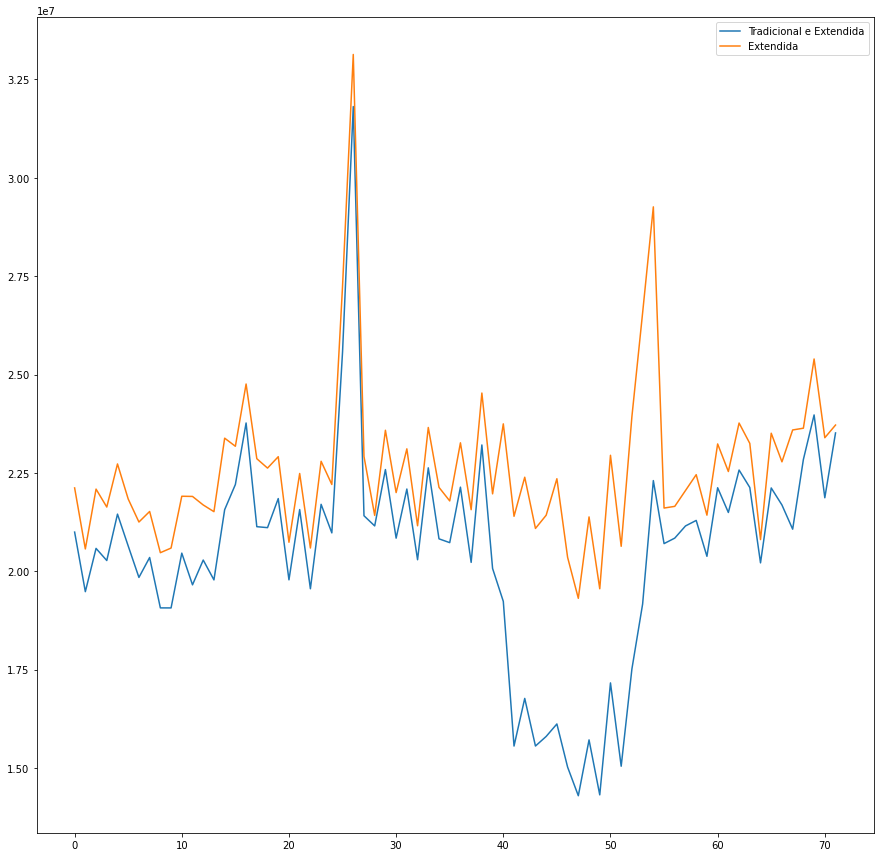

In [93]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida','Extendida']);

<AxesSubplot:xlabel='year', ylabel='sales'>

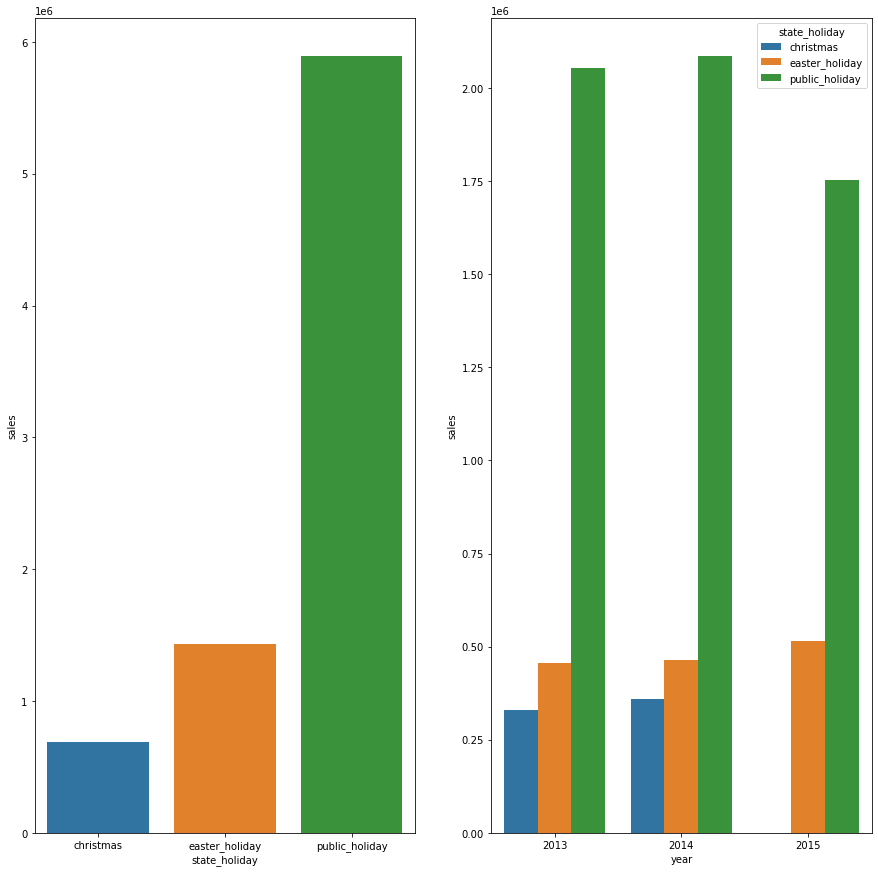

In [94]:
# 7 Lojas abertas durante o feriado de natal deveriam vender mais.
# falsa, porque lojas abertas durante o feriado do natal, vendem menos

aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y='sales', hue='state_holiday', data=aux2)

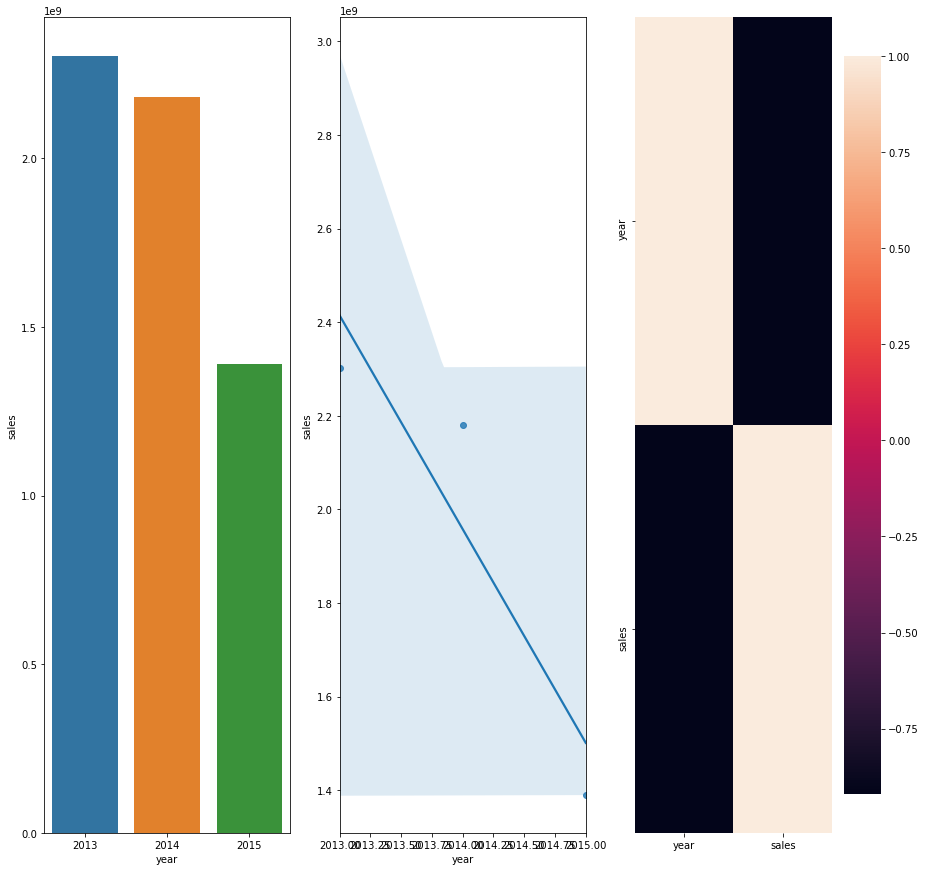

In [95]:
# 8 Lojas deveriam vender mais ao longo dos anos.
# Falsa, lojas vendem menos ao longo dos anos.

aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'));

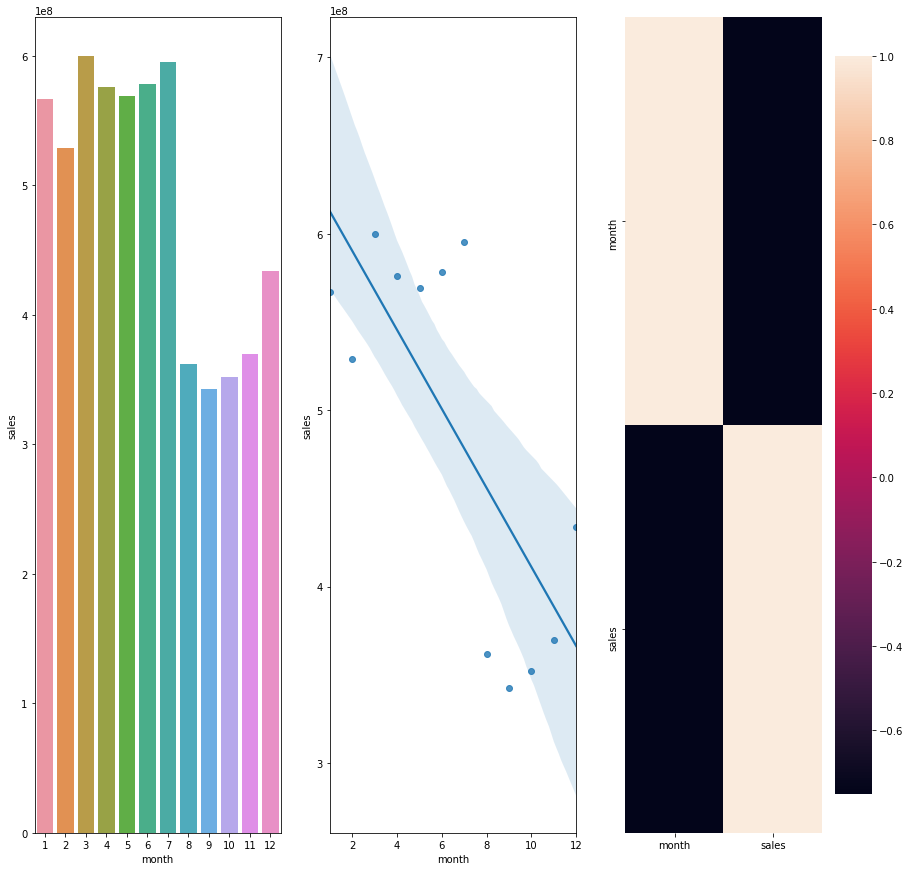

In [96]:
# 9 Lojas deveriam vender mais no segundo semestre do ano.
# Falso, as lojas vendem menos no segundo semestre do ano.

aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'));

<AxesSubplot:xlabel='before_after', ylabel='sales'>

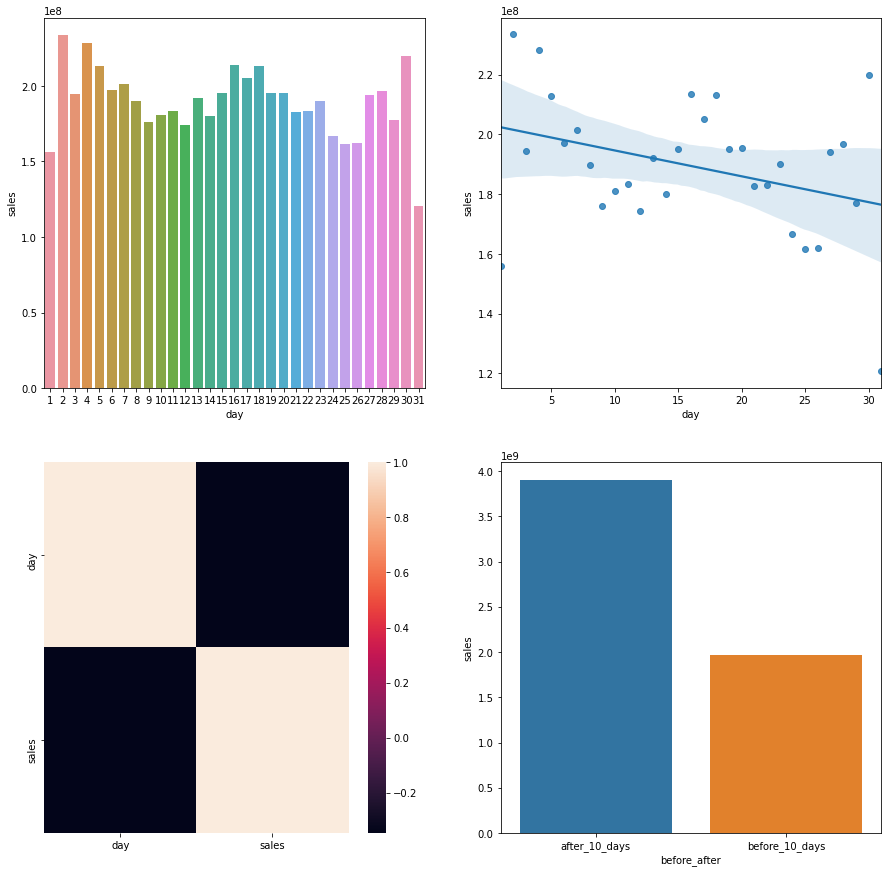

In [97]:
# 10 Lojas deveriam vender mais depois do dia 10 de cada mês.
# Verdadeira, lojas vendem mais depois do dia 10 de cada mês.

aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x = 'day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'));

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'before_after', y='sales', data=aux2)



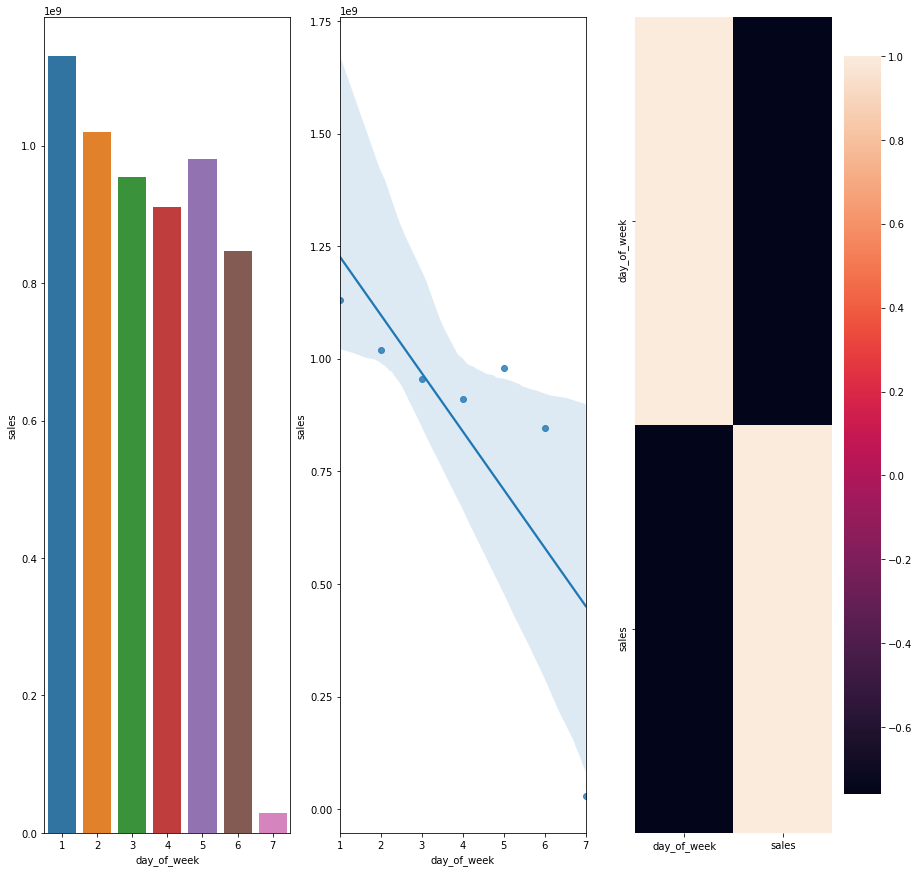

In [98]:
# 11 Lojas deveriam vender menos aos finais de semana.
# Verdade, as lojas vendem menos nos finais de semana.
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'));

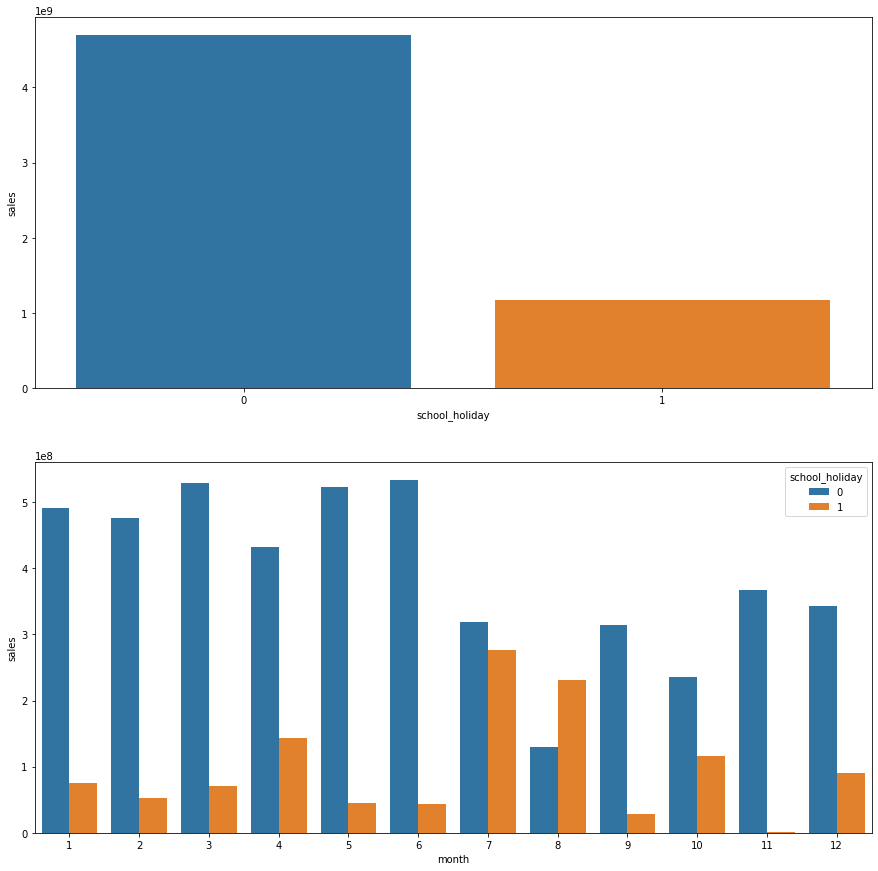

In [99]:
# 12 Lojas deveriam vender menos durante os feriados escolares.
# Verdadeira,lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto.

aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x ='school_holiday', y='sales', data=aux1);

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x ='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 Resumo das Hipóteses

In [100]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
        ['H1','Falsa','Baixa'],
        ['H2','Falsa','Media'],
        ['H3','Falsa','Media'],
        ['H4','Falsa','Baixa'],
        ['H5','-','-'],
        ['H6','Falsa','Baixa'],
        ['H7','Falsa','Media'],
        ['H8','Falsa','Alta'],
        ['H9','Falsa','Baixa'],
        ['H10','Verdadeira','Alta'],
        ['H11','Verdadeira','Alta'],
        ['H12','Verdadeira','Baixa'],
      ]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Baixa
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise multivariada

### 4.3.1 Atributos numéricos

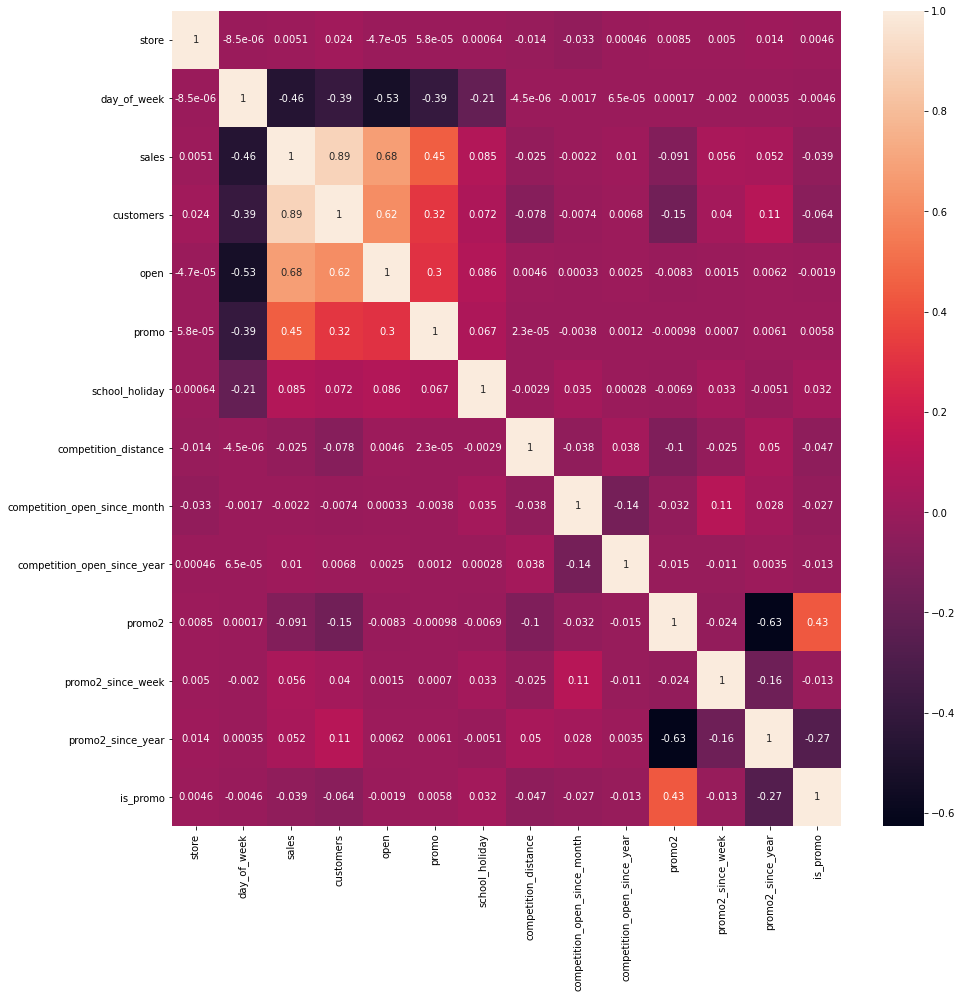

In [80]:
plt.rcParams['figure.figsize']=(15,15)
correlation = num_attributes.corr(method='pearson')
sns.heatmap( correlation, annot=True);

### 4.3.2 Atributos categóricos

In [115]:
a = df4.select_dtypes(include='object')

a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [169]:
# v de cramer

def cramer_v( x, y):
    cm = pd.crosstab(x, y).values
    
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))
    

In [173]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9],})

d = d.set_index(d.columns)

<AxesSubplot:>

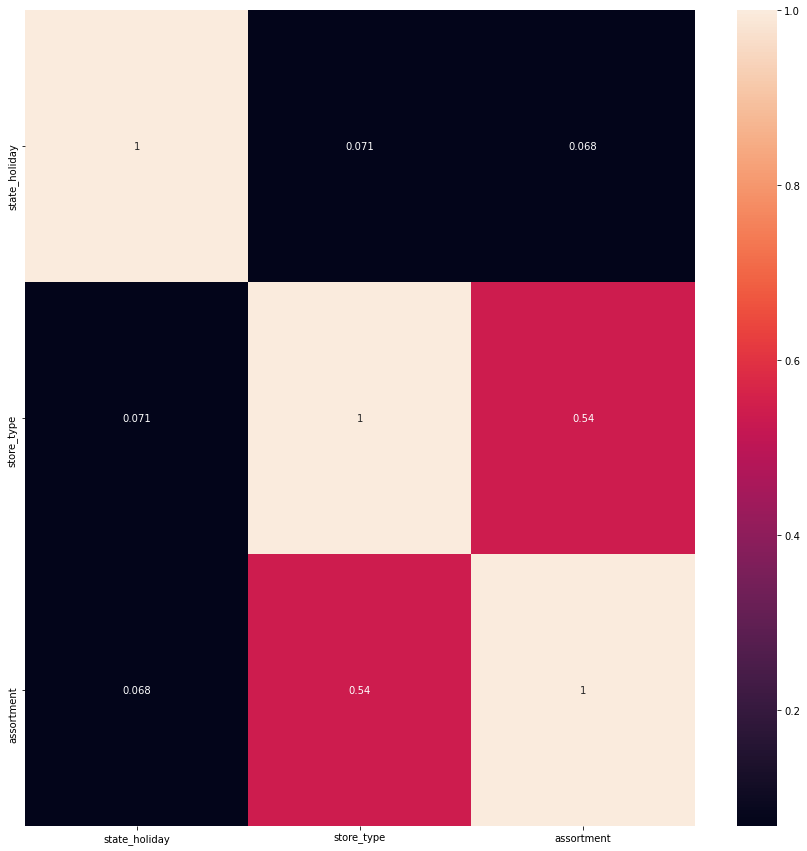

In [174]:
sns.heatmap(d, annot=True)